In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import re

df = pd.read_csv("/content/drive/MyDrive/NLP projektas/math_solutions.csv")

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"\[abs\]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = text.replace("\n", " ")
    return text

df["clean_text"] = df["text"].apply(clean_text)

df.head()

,text,type,clean_text
0,We roll a fair 6-sided die 5 times. What is t...,Counting & Probability,We roll a fair 6-sided die 5 times. What is th...
1,"When counting from $3$ to $201$, $53$ is the $...",Counting & Probability,"When counting from $3$ to $201$, $53$ is the $..."
2,Find the value of $n$ that satisfies $2(n+1)!+...,Counting & Probability,Find the value of $n$ that satisfies $2(n+1)!+...
3,I draw a card from a standard 52-card deck. I...,Counting & Probability,I draw a card from a standard 52-card deck. If...
4,How many subsets of the set of divisors of $72...,Counting & Probability,How many subsets of the set of divisors of $72...


In [3]:
df["type"].value_counts()

,count
type,
Algebra,2931
Intermediate Algebra,2198
Prealgebra,2076
Number Theory,1409
Geometry,1348
Precalculus,1291
Counting & Probability,1245


In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["label_id"] = le.fit_transform(df["type"])

label_names = list(le.classes_)
label_names

['Algebra',
 'Counting & Probability',
 'Geometry',
 'Intermediate Algebra',
 'Number Theory',
 'Prealgebra',
 'Precalculus']

In [6]:
from transformers import BertTokenizer, TFBertModel, TFBertForSequenceClassification
import tensorflow as tf
import torch

model_path = "/content/drive/MyDrive/mathbert_finetuned"

tokenizer = BertTokenizer.from_pretrained(model_path)

model = TFBertModel.from_pretrained(model_path)
model.trainable = False




TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some layers from the model checkpoint at /content/drive/MyDrive/mathbert_finetuned were not used when initializing TFBertModel: ['classifier', 'dropout_75']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at /content/drive/MyDrive/mathbert_finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TF

In [7]:
texts = df["clean_text"].tolist()
labels = df["label_id"].values

In [8]:
import numpy as np
from tqdm import tqdm

def get_embeddings(texts, batch_size=16):
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        encoded = tokenizer(batch_texts,
                            padding=True,
                            truncation=True,
                            max_length=256,
                            return_tensors="tf")
        outputs = model(encoded)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]
        all_embeddings.append(cls_embeddings.numpy())
    return np.vstack(all_embeddings)

embeddings = get_embeddings(texts)
print("Embeddings shape:", embeddings.shape)

100%|██████████| 782/782 [04:42<00:00,  2.77it/s]

Embeddings shape: (12498, 768)


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    embeddings, labels, test_size=0.2, stratify=labels, random_state=1117
)

X_val, X_test_final, y_val, y_test_final = train_test_split(
    X_test,
    y_test,
    test_size=0.5,
    stratify=y_test,
    random_state=1117
)


In [10]:
param_grid_lr = {
    "C": [0.1, 1, 3, 10],
    "penalty": ["l2"],
    "solver": ["lbfgs"],
    "max_iter": [1000]
}
param_grid_rf = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20]
}
param_grid_svm = {
    "C": [0.5, 1, 2],
    "gamma": ["scale", 0.1, 0.01]
}
param_grid_knn = {
    "n_neighbors": [3, 5, 7, 9],
    "weights": ["uniform", "distance"],
    "p": [1, 2]
}

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best macro F1: 0.9803394358655831

Macro F1 (test dataset): 0.7977005213146386
Accuracy score (test dataset): 0.7936


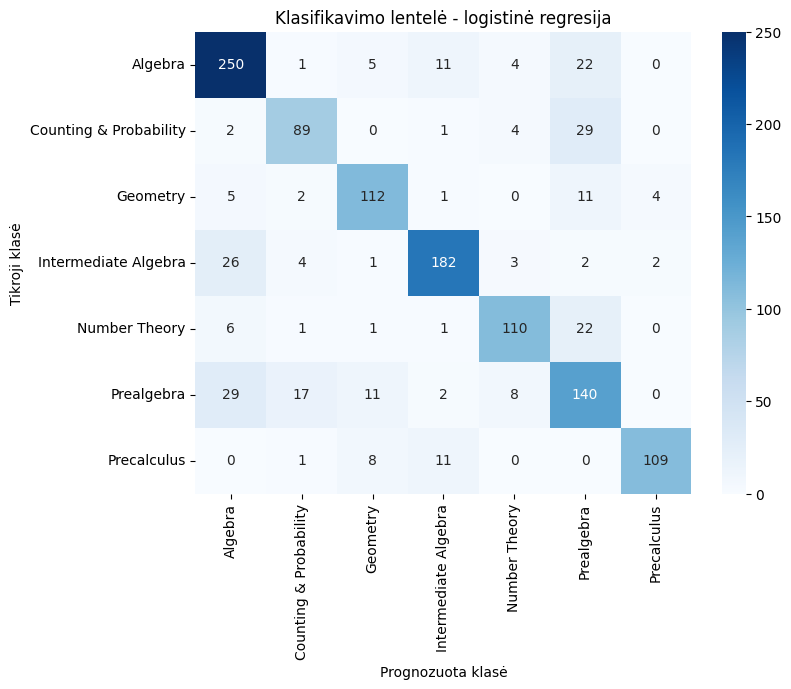

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

lr = LogisticRegression()

grid = GridSearchCV(
    estimator=lr,
    param_grid=param_grid_lr,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

print("Best parameters:", grid.best_params_)
print("Best macro F1:", grid.best_score_)

y_pred = best_model.predict(X_test_final)

accuracy_lr = accuracy_score(y_test_final, y_pred)
f1_lr = f1_score(y_test_final, y_pred, average="macro")
print("\nMacro F1 (test dataset):", f1_lr)
print("Accuracy score (test dataset):", accuracy_lr)
cm = confusion_matrix(y_test_final, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Prognozuota klasė")
plt.ylabel("Tikroji klasė")
plt.title("Klasifikavimo lentelė - logistinė regresija")
plt.show()

Fitting 2 folds for each of 9 candidates, totalling 18 fits
Best parameters: {'C': 1, 'gamma': 'scale'}
Best macro F1: 0.9796905292534634
Macro F1 (test dataset): 0.8094950101053052

Accuracy score (test dataset): 0.8064


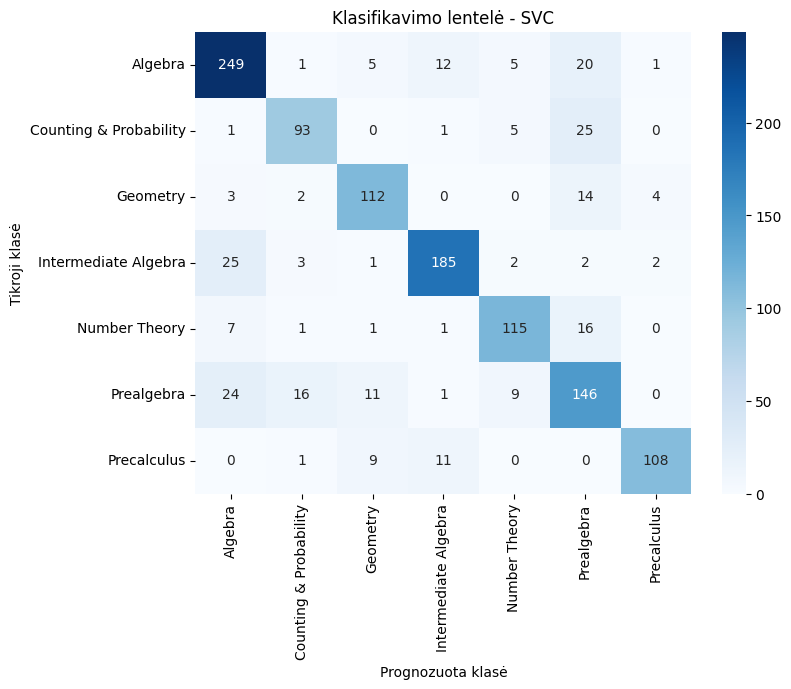

In [16]:
from sklearn.svm import SVC
svm = SVC()

grid = GridSearchCV(
    estimator=svm,
    param_grid=param_grid_svm,
    scoring="f1_macro",
    cv=2,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

print("Best parameters:", grid.best_params_)
print("Best macro F1:", grid.best_score_)

y_pred = best_model.predict(X_test_final)

accuracy_svm = accuracy_score(y_test_final, y_pred)
f1_svm = f1_score(y_test_final, y_pred, average="macro")
print("Macro F1 (test dataset):", f1_svm)
print("\nAccuracy score (test dataset):", accuracy_svm)
cm = confusion_matrix(y_test_final, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Prognozuota klasė")
plt.ylabel("Tikroji klasė")
plt.title("Klasifikavimo lentelė - SVC")
plt.show()

Fitting 2 folds for each of 9 candidates, totalling 18 fits
Best parameters: {'max_depth': None, 'n_estimators': 200}
Best macro F1: 0.9783221287747678

Macro F1 (test dataset): 0.8050454446337405
Accuracy score (test dataset): 0.7992


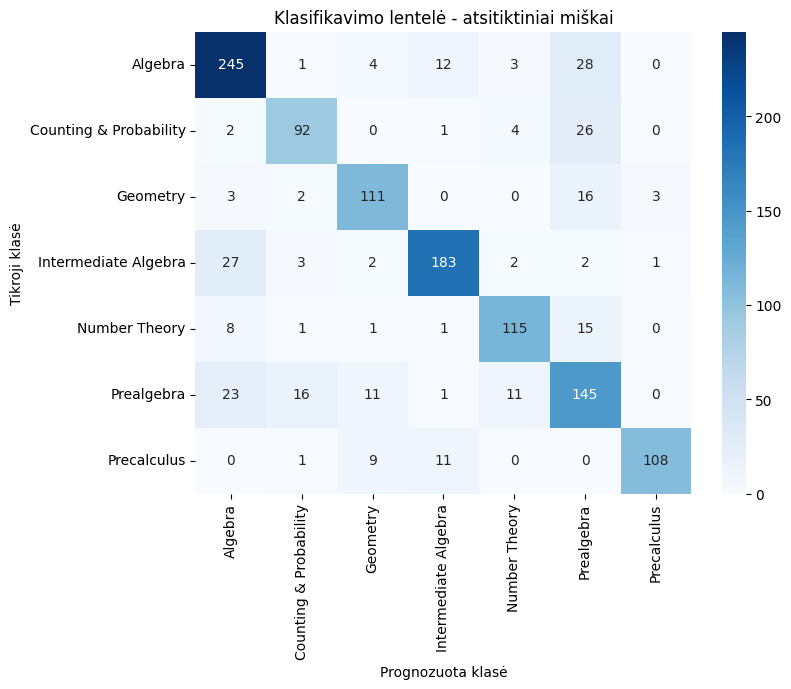

In [17]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring="f1_macro",
    cv=2,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

print("Best parameters:", grid.best_params_)
print("Best macro F1:", grid.best_score_)

y_pred = best_model.predict(X_test_final)

accuracy_rf = accuracy_score(y_test_final, y_pred)
f1_rf = f1_score(y_test_final, y_pred, average="macro")
print("\nMacro F1 (test dataset):", f1_rf)
print("Accuracy score (test dataset):", accuracy_rf)
cm = confusion_matrix(y_test_final, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Prognozuota klasė")
plt.ylabel("Tikroji klasė")
plt.title("Klasifikavimo lentelė - atsitiktiniai miškai")
plt.show()

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters: {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Best macro F1: 0.9766804887598948

Macro F1 (test dataset): 0.8085118885715683
Accuracy score (test dataset): 0.8032


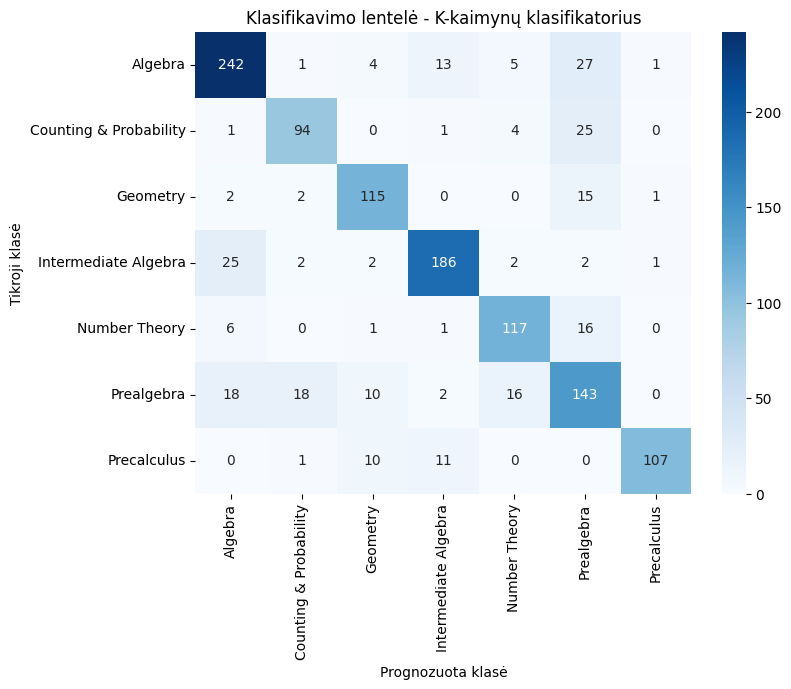

In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

grid = GridSearchCV(
    estimator=knn,
    param_grid=param_grid_knn,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

print("Best parameters:", grid.best_params_)
print("Best macro F1:", grid.best_score_)

y_pred = best_model.predict(X_test_final)

accuracy_knn = accuracy_score(y_test_final, y_pred)
f1_knn = f1_score(y_test_final, y_pred, average="macro")
print("\nMacro F1 (test dataset):", f1_knn)
print("Accuracy score (test dataset):", accuracy_knn)
cm = confusion_matrix(y_test_final, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Prognozuota klasė")
plt.ylabel("Tikroji klasė")
plt.title("Klasifikavimo lentelė - K-kaimynų klasifikatorius")
plt.show()

In [30]:
import pandas as pd

accuracy_mathbert = 0.78
f1_mathbert = 0.7848

df = pd.DataFrame({
    "Model": ["Logistic Regression", "SVC", "Random Forest", "KNN", "MathBERT"],
    "Tikslumas": [accuracy_lr, accuracy_svm, accuracy_rf, accuracy_knn, accuracy_mathbert],
    "Makro F1": [f1_lr, f1_svm, f1_rf, f1_knn, f1_mathbert]
})

df[["Tikslumas", "Makro F1"]] = df[["Tikslumas", "Makro F1"]] * 100

df_long = df.melt(id_vars="Model",
                  value_vars=["Tikslumas", "Makro F1"],
                  var_name="Metric",
                  value_name="Value")

In [31]:
df_long

,Model,Metric,Value
0,Logistic Regression,Tikslumas,79.360000
1,SVC,Tikslumas,80.640000
2,Random Forest,Tikslumas,79.920000
3,KNN,Tikslumas,80.320000
4,MathBERT,Tikslumas,78.000000
5,Logistic Regression,Makro F1,79.770052
6,SVC,Makro F1,80.949501
7,Random Forest,Makro F1,80.504544
8,KNN,Makro F1,80.851189
9,MathBERT,Makro F1,78.480000


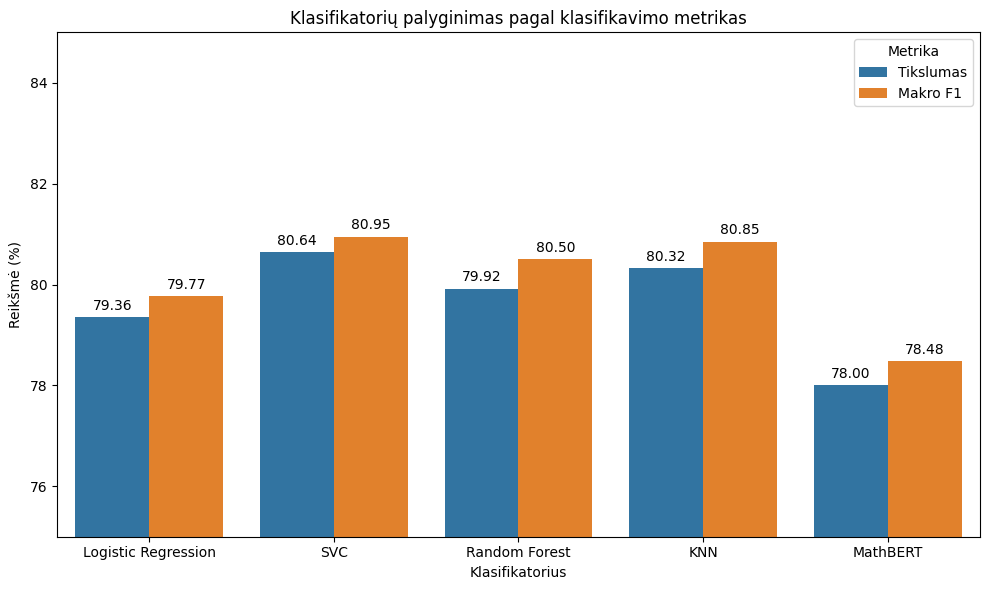

In [32]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_long, x="Model", y="Value", hue="Metric")
plt.title("Klasifikatorių palyginimas pagal klasifikavimo metrikas")
plt.ylabel("Reikšmė (%)")
plt.xlabel("Klasifikatorius")

plt.ylim(75, 85)

plt.legend(title="Metrika")
plt.xticks(rotation=0)
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.tight_layout()
plt.show()